##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

In [100]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

import matplotlib.pyplot as plt
from wordcloud import WordCloud

### <u>Split training and testing data</u> ###

**Learning curve**

In [183]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

In [184]:
def generate_learning_curve(df, classifier, y_min=0.5, y_max=1.0):
    X = df['text']
    y = df['sentiment']
        
    tfidf_pipeline = make_pipeline(TfidfVectorizer(), classifier)
    train_sizes, train_scores, test_scores = learning_curve(tfidf_pipeline, X, y, train_sizes=np.arange(0.1, 1.0, 0.1))
    
    plt.subplots(1, figsize=(8, 5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1))
    plt.plot(train_sizes, np.mean(test_scores, axis=1))
    plt.xlabel('Training proportion (%)')
    plt.xticks(train_sizes, labels=(np.arange(0.1, 1.0, 0.1)*100).astype(int))
    plt.ylim((y_min, y_max))
    plt.ylabel('Accuracy')
    plt.show()

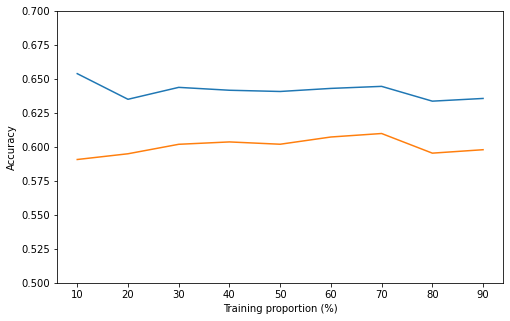

In [164]:
generate_learning_curve(df, MultinomialNB(), 0.5, 0.7)

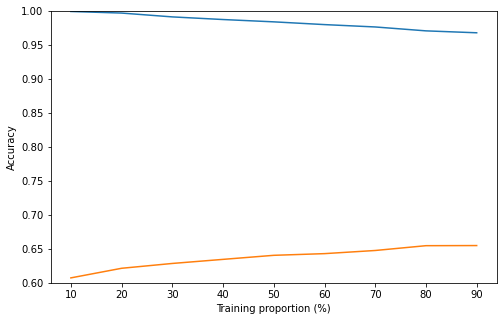

In [182]:
generate_learning_curve(df, svm.LinearSVC(), 0.6, 1.0)

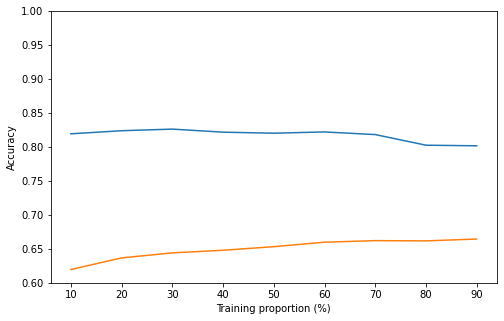

In [181]:
generate_learning_curve(df, LogisticRegression(max_iter=300), 0.6, 0.9)

**Function**

In [50]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.9

def data_split(df, test_size=TEST_SIZE):
    X = df['text']
    y = df['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

### <u>Feature vectorization</u> ###

In [51]:
def vectorise(train, test, method):
    vectorizer = method
    
    vectorised_train = vectorizer.fit_transform(train)
    vectorised_test = vectorizer.transform(test)
    
    return vectorised_train, vectorised_test

### <u>Fitting, predicting and evaluation</u> ###

In [85]:
def evaluate(actual_classes, pred_classes, accuracy=True, fscore=True, confusion=True, average_method='macro'):
    if accuracy:
        accuracy = accuracy_score(actual_classes, pred_classes)   
        print('Accuracy:', accuracy)

    if fscore:
        precision, recall, fscore, support = precision_recall_fscore_support(actual_classes, pred_classes, 
                                                                    labels=['positive', 'negative', 'neutral'],
                                                                   average=average_method,
                                                                    zero_division=0)
        print('Precision:', precision)
        print('Recall:', recall)
        print('Fscore:', fscore)
    
    if confusion:
        confusion_display = pd.DataFrame(confusion_matrix(actual_classes, pred_classes, labels=['positive', 'negative', 'neutral']),
                                        index=['actual: positive', 'actual: negative', 'actual: neutral'],
                                        columns=['pred: positive', 'pred: negative', 'pred: neutral'])
        print('Confusion matrix:\n', confusion_display)
    
    print('')

In [86]:
def fit_predict_evaluate(X_train, y_train, X_test, y_test,
                         base_models, titles, display='all', meta_classifier='logistic',
                         accuracy=True, fscore=True, confusion=True, average_method='macro'):
    # base models
    if display == 'base' or display == 'all':
        for title, model in zip(titles, base_models): 
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            print(title)
            evaluate(y_test, pred, accuracy=accuracy, fscore=fscore, confusion=confusion, average_method=average_method)

    # stacked model
    if display == 'stacked' or display == 'all':
        # format base models for stacking classifier input
        zipped_models = [list(model) for model in zip(titles, base_models)][1:]
        if meta_classifier == 'logistic':
            stack_model = StackingClassifier(estimators=zipped_models, final_estimator=LogisticRegression(max_iter=300))
        elif meta_classifier == 'decision-tree':
            stack_model = StackingClassifier(estimators=zipped_models, final_estimator=DecisionTreeClassifier())
        
        stack_model.fit(X_train, y_train)
        stack_pred = stack_model.predict(X_test)
        print('Stacked model')
        evaluate(y_test, stack_pred, accuracy=accuracy, fscore=fscore, confusion=confusion, average_method=average_method)

### <u>Data cleaning and stemming</u> ###

#### Functions ####

In [54]:
import re
from nltk.corpus import stopwords

def clean(texts, feature=None, remove_instance=True):
    cleaned_text = texts
    if feature == 'username' or feature == 'all':
        if remove_instance:
            pattern = r'@(\w+)+'
        else:
            pattern = r'@'
        cleaned_text = cleaned_text.str.replace(pattern, '', regex=True)
        
    if feature == 'hashtag' or feature == 'all':
        if remove_instance:
            pattern = r'#(\w+)+'
        else:
            pattern = r'#'
        cleaned_text = cleaned_text.str.replace(pattern, '', regex=True)
        
    if feature == 'url' or feature == 'all':
        cleaned_text = cleaned_text.str.replace(r'https?:\/\/\S+', '', regex=True)
        
    if feature == 'non-alphanumeric' or feature == 'all':
        cleaned_text = cleaned_text.str.replace(r'[^a-zA-Z0-9 #]', '', regex=True)
    
    return cleaned_text

def remove_stopwords(texts):
    stop_words = set(stopwords.words('english'))
    tokenized_texts = texts.str.split(' ')
    tokenized_texts = tokenized_texts.apply(lambda sentence: [word for word in sentence if word not in stop_words])
    return tokenized_texts.str.join(' ')
    
def stem(texts, method):
    tokenized_texts = texts.str.split(' ')
    tokenized_texts = tokenized_texts.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
    return tokenized_texts.str.join(' ')

#### Experiments ####

In [7]:
base_models = [MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  

**Removing features one by one + removing whole instances**

In [87]:
features = [None,
            'username',
            'hashtag',
            'url',
            'non-alphanumeric', 
            'all']

# loop over which removes whole instances
for removed_feature in features:
    print('################################################################################################################')
    print('Removing feature:', removed_feature)
    df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

    df['text'] = clean(df['text'], feature=removed_feature)

    X_train, X_test, y_train, y_test = data_split(df)
    
    X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())
    print('# of features: ', X_train_tfidf.shape[1])
    print('')

    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                         base_models, titles, display='base',
                         fscore=False, confusion=False)

################################################################################################################
Removing feature: None
# of features:  40845

Multinomial NB
Accuracy: 0.6011004126547456

Linear SVC
Accuracy: 0.672627235213205

Logistic Regression
Accuracy: 0.6762952773956901

################################################################################################################
Removing feature: username
# of features:  34478

Multinomial NB
Accuracy: 0.6015589179275561

Linear SVC
Accuracy: 0.6680421824850986

Logistic Regression
Accuracy: 0.6813388353966071

################################################################################################################
Removing feature: hashtag
# of features:  38093

Multinomial NB
Accuracy: 0.6006419073819349



KeyboardInterrupt: 

**Comparison of removing the whole instance or just the character for hashtag and usernames**

In [20]:
features = ['username',
            'hashtag']

# loop over which removes whole instances
for removed_feature in features:
    print('################################################################################################################')
    print('Removing feature:', removed_feature)
    for remove_instance in True,False:
        print('Removing entire instance:', remove_instance)
        df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

        df['text'] = clean(df['text'], feature=removed_feature, remove_instance=remove_instance)

        X_train, X_test, y_train, y_test = data_split(df)

        X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

        print('# of features: ', X_train_tfidf.shape[1])
        print('')
        
        fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                             base_models, titles, display='base',
                             fscore=False, confusion=False)
        print('')

################################################################################################################
Removing feature: username
Removing entire instance: True
# of features:  35280

Multinomial NB
Accuracy: 0.6015589179275561

Linear SVC
Accuracy: 0.6680421824850986

Logistic Regression
Accuracy: 0.6799633195781751


Removing entire instance: False
# of features:  40857

Multinomial NB
Accuracy: 0.6011004126547456

Linear SVC
Accuracy: 0.6717102246675837

Logistic Regression
Accuracy: 0.6758367721228794


################################################################################################################
Removing feature: hashtag
Removing entire instance: True
# of features:  38123

Multinomial NB
Accuracy: 0.6006419073819349

Linear SVC
Accuracy: 0.6643741403026134

Logistic Regression
Accuracy: 0.6730857404860155


Removing entire instance: False
# of features:  40903

Multinomial NB
Accuracy: 0.6011004126547456

Linear SVC
Accuracy: 0.672627235213205

Logisti

### <u>Data analysis</u> ###

In [22]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)
df['text'] = clean(df['text'], feature='all')

**Wordcloud**

In [23]:
def generate_wordcloud(df, sentiment):
    words = " ".join([tweet for tweet in df['text'][df['sentiment'] == sentiment]])
    wordcloud = WordCloud(random_state=42).generate(words)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud)
    plt.title(sentiment)
    plt.axis('off')
    plt.show()

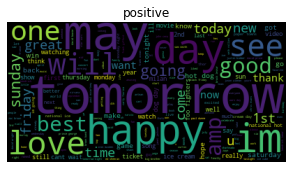

In [24]:
generate_wordcloud(df, 'positive')

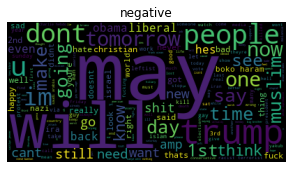

In [25]:
generate_wordcloud(df, 'negative')

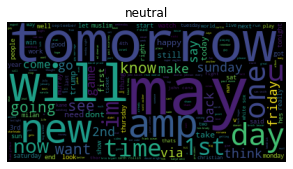

In [26]:
generate_wordcloud(df, 'neutral')

**Sentiment distribution**

<AxesSubplot:title={'center':'Sentiment distribution'}>

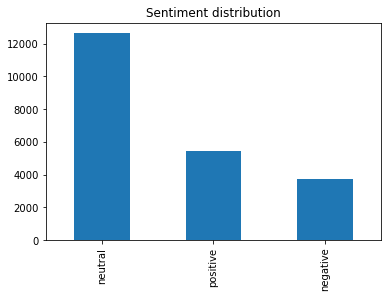

In [10]:
plt.title('Sentiment distribution')
df['sentiment'].value_counts().plot(kind='bar')

**Hashtag graph**

In [20]:
def extract_hashtags(df, sentiment):
    tweets = df['text'][df['sentiment'] == sentiment]
    hashtags = []
    
    for tweet in tweets:
        hashtags.append(re.findall(r'#(\w+)+', tweet))
        
    return pd.Series(sum(hashtags, []))

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

<AxesSubplot:>

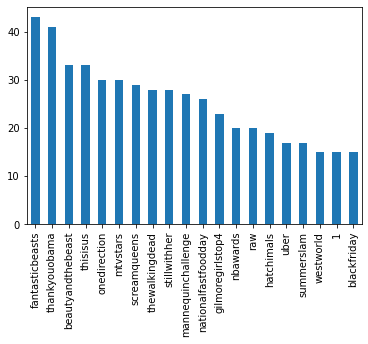

In [22]:
extract_hashtags(df, 'positive').value_counts()[0:20].plot(kind='bar')

<AxesSubplot:>

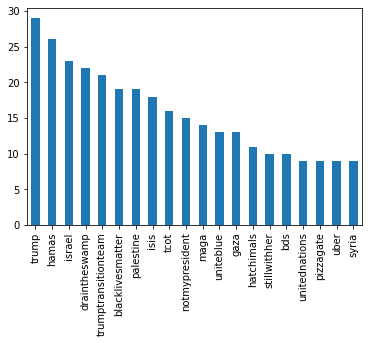

In [23]:
extract_hashtags(df, 'negative').value_counts()[0:20].plot(kind='bar')

<AxesSubplot:>

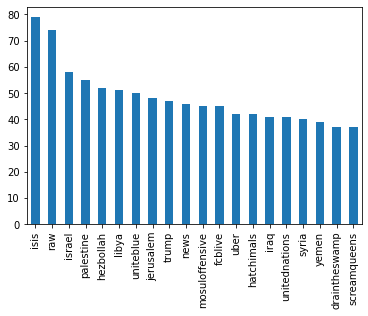

In [24]:
extract_hashtags(df, 'neutral').value_counts()[0:20].plot(kind='bar')

### <u>Sampling distribution experiments</u> ###

In [16]:
base_models = [DummyClassifier(strategy='most_frequent'),
               MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Zero-R',
          'Multinomial NB',
          'Linear SVC',
          'Logistic Regression'] 

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'], feature='all')

X_train, X_test, y_train, y_test = data_split(df)
X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

**No imbalance method**

In [9]:
fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, 
                     fscore=False, confusion=False)

Zero-R
Accuracy: 0.5905547913801009

Multinomial NB
Accuracy: 0.6066024759284732

Linear SVC
Accuracy: 0.6671251719394773

Logistic Regression
Accuracy: 0.6730857404860155

Stacked model
Accuracy: 0.6785878037597433



**Random under-sampling**

In [10]:
rus = RandomUnderSampler(random_state=42, replacement=True)

X_train_tfidf_rus, y_train_rus = rus.fit_resample(X_train_tfidf, y_train)

fit_predict_evaluate(X_train_tfidf_rus, y_train_rus, X_test_tfidf, y_test, 
                     base_models, titles, 
                     confusion=False)

**Random over-sampling**

In [15]:
ros = RandomOverSampler(random_state=42)

X_train_tfidf_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

fit_predict_evaluate(X_train_tfidf_ros, y_train_ros, X_test_tfidf, y_test, 
                     base_models, titles, 
                     confusion=False)

Zero-R
Accuracy: 0.17423200366804217

Multinomial NB
Accuracy: 0.5414947271893626

Linear SVC
Accuracy: 0.6198991288399817

Logistic Regression
Accuracy: 0.6263182026593306

Stacked model
Accuracy: 0.6377808344795965



**SMOTE: Synthetic Minority Over-sampling Technique**

In [19]:
smt = SMOTE(random_state=777, k_neighbors=1)

X_train_tfidf_smt, y_train_smt = smt.fit_resample(X_train_tfidf, y_train)

fit_predict_evaluate(X_train_tfidf_smt, y_train_smt, X_test_tfidf, y_test, 
                     base_models, titles, 
                     confusion=False)

Zero-R
Accuracy: 0.17423200366804217

Multinomial NB
Accuracy: 0.5502063273727648

Linear SVC
Accuracy: 0.630903255387437

Logistic Regression
Accuracy: 0.6373223292067859

Stacked model
Accuracy: 0.6432828977533241



**Class weight**

In [ ]:
base_models = [DummyClassifier(strategy='most_frequent'),
               MultinomialNB(),
              svm.LinearSVC(class_weight='balanced'),
              LogisticRegression(max_iter=300, class_weight='balanced')]

fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, 
                     confusion=False)

Multinomial NB
Accuracy: 0.5905547913801009

Precision: 0.1968515971267003
Recall: 0.3333333333333333
Fscore: 0.24752570385317574

Linear SVC
Accuracy: 0.6011004126547456

Precision: 0.8010122996130459
Recall: 0.35124233692120804
Fscore: 0.2857998235241039

Logistic Regression
Accuracy: 0.6515359926639156

Precision: 0.6055962796425205
Recall: 0.615207402564382
Fscore: 0.6095457622903924



### <u>Hyperparameters experiments</u> ###

In [8]:
df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)
X_train, X_test, y_train, y_test = data_split(df)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

**Multinomial Naive Bayes**

In [16]:
hyperparam_alpha = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]


for alpha in hyperparam_alpha:
    print('################################################################################################################')
    base_model = [MultinomialNB(alpha=alpha)]
    title = ['Multinomial NB, alpha = ' + str(alpha)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base',
                     confusion=False)

################################################################################################################
Multinomial NB, alpha = 0.01
Accuracy: 0.6166895919303071

Precision: 0.5596913899221924
Recall: 0.5074962971034672
Fscore: 0.5232332276121404

################################################################################################################
Multinomial NB, alpha = 0.05
Accuracy: 0.6304447501146263

Precision: 0.5847917221270559
Recall: 0.5080311487252753
Fscore: 0.527928667593275

################################################################################################################
Multinomial NB, alpha = 0.1
Accuracy: 0.6350298028427327

Precision: 0.6034873905244275
Recall: 0.48798627002288325
Fscore: 0.5091602123852296

################################################################################################################
Multinomial NB, alpha = 0.5
Accuracy: 0.6166895919303071

Precision: 0.7284110605099826
Recall: 0.38180051578220914
F

**Support Vector Machine**

In [13]:
hyperparam_C = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0]

for C in hyperparam_C:
    print('################################################################################################################')
    base_model = [svm.LinearSVC(C=C, max_iter=5000)]
    title = ['Linear SVC, C = ' + str(C)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base',
                     confusion=False)

################################################################################################################
Linear SVC, C = 0.1
Accuracy: 0.6652911508482348

Precision: 0.6620077911394685
Recall: 0.5124394117338434
Fscore: 0.5335466416083552

################################################################################################################
Linear SVC, C = 0.5
Accuracy: 0.6799633195781751

Precision: 0.6505697852993658
Recall: 0.5820571961304227
Fscore: 0.604374683649759

################################################################################################################
Linear SVC, C = 1.0
Accuracy: 0.672627235213205

Precision: 0.6352572682124352
Recall: 0.5876829755548291
Fscore: 0.6049971444530838

################################################################################################################
Linear SVC, C = 10.0
Accuracy: 0.6231086657496562

Precision: 0.5703627600139801
Recall: 0.5700537575823618
Fscore: 0.5695415006175796

#########

In [16]:
hyperparam_multiclass = ['one v one', 'one v rest']

for multi_class in hyperparam_multiclass:
    print('################################################################################################################')
    if multi_class == 'one v one':
        base_model = [OneVsOneClassifier(svm.LinearSVC())]
    elif multi_class == 'one v rest':
        base_model = [svm.LinearSVC()]
        
    title = ['Linear SVC, multiclass technique = ' + str(multi_class)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base')

################################################################################################################
Linear SVC, multiclass technique = one v one
Accuracy: 0.672627235213205

Precision: 0.6361967071437674
Recall: 0.5879462141666566
Fscore: 0.6054085935294369

Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive             286               6            221
actual: negative              22             156            202
actual: neutral              161             102           1025

################################################################################################################
Linear SVC, multiclass technique = one v rest
Accuracy: 0.672627235213205

Precision: 0.6352572682124352
Recall: 0.5876829755548291
Fscore: 0.6049971444530838

Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive             279              14            220
actual: negative              24

**Logistic regression**

In [18]:
hyperparam_C = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0]

for C in hyperparam_C:
    print('################################################################################################################')
    title = ['Logistic Regression, C = ' + str(C)]
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_model, title, display='base',
                     confusion=False)

################################################################################################################
Logistic Regression, C = 0.1
Accuracy: 0.6217331499312242

Precision: 0.5645742057506764
Recall: 0.4014949814148898
Fscore: 0.3748486481113928

################################################################################################################
Logistic Regression, C = 0.5
Accuracy: 0.6689591930307198

Precision: 0.6692658690541698
Recall: 0.5178291945645112
Fscore: 0.5416605853823481

################################################################################################################
Logistic Regression, C = 1.0
Accuracy: 0.6762952773956901

Precision: 0.6577923476551728
Recall: 0.551596785845451
Fscore: 0.5779703613414234

################################################################################################################
Logistic Regression, C = 5.0
Accuracy: 0.6730857404860155

Precision: 0.6384641892840421
Recall: 0.5867049871054447
F

**Stacking Meta Classifier**

In [39]:
base_models = [MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression'] 

meta_classifiers = ['logistic', 'decision-tree']

for meta_classifier in meta_classifiers:
    print('################################################################################################################')
    print('Stacking meta classifier: ', meta_classifier)
    print('')
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                     base_models, titles, display='stacked', meta_classifier=meta_classifier,
                     confusion=False)


################################################################################################################
Stacking meta classifier:  logistic

Stacked model
Accuracy: 0.6795048143053645

Precision: 0.6473353398798262
Recall: 0.5914372283365418
Fscore: 0.6115213600756996

################################################################################################################
Stacking meta classifier:  decision-tree

Stacked model
Accuracy: 0.5602934433745989

Precision: 0.5041065940381776
Recall: 0.5159390020946085
Fscore: 0.5091778687267706



**TF-IDF Minimum DF**

In [89]:
base_models = [MultinomialNB(),
              svm.LinearSVC(),
              LogisticRegression(max_iter=300)]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression'] 

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'], feature='all')

X_train, X_test, y_train, y_test = data_split(df)

thresholds = [0, 0.01, 0.05, 0.1, 0.5]

for min_threshold in thresholds:
    print('################################################################################################################')
    print('Minimum document frequency: ', min_threshold)
    print('')
    
    X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer(min_df=min_threshold))
    
    fit_predict_evaluate(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                         base_models, titles, display='base', 
                         fscore=False, confusion=False)

################################################################################################################
Minimum document frequency:  0

Multinomial NB
Accuracy: 0.6075194864740945

Linear SVC
Accuracy: 0.6620816139385602

Logistic Regression
Accuracy: 0.6762952773956901

################################################################################################################
Minimum document frequency:  0.01

Multinomial NB
Accuracy: 0.6102705181109582

Linear SVC
Accuracy: 0.6263182026593306

Logistic Regression
Accuracy: 0.6254011921137093

################################################################################################################
Minimum document frequency:  0.05

Multinomial NB
Accuracy: 0.5905547913801009

Linear SVC
Accuracy: 0.5864282439248051

Logistic Regression
Accuracy: 0.5855112333791839

################################################################################################################
Minimum document frequency:  0.1

Mult

### <u>Classification testing main</u> ###

#### Feature reduction testing ####

In [17]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'])
df['text'] = remove_stopwords(df['text'])

X_train, X_test, y_train, y_test = data_split(df)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

base_models = [DummyClassifier(strategy='most_frequent'),
              MultinomialNB(),
              svm.LinearSVC(class_weight='balanced'),
              LogisticRegression(max_iter=300, class_weight='balanced')]

titles = ['Zero-R',
          'Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  

# base models
for title, model in zip(titles, base_models): 
    model.fit(X_train_tfidf, y_train)
    pred = model.predict(X_test_tfidf)
    print('################################################################################################################')
    print(title)
    evaluate(y_test, pred)

zipped_models = [list(model) for model in zip(titles, base_models)][1:]
stack_model = StackingClassifier(estimators=zipped_models, final_estimator=LogisticRegression(max_iter=300))

# stacked model
stack_model.fit(X_train_tfidf, y_train)
stack_pred = stack_model.predict(X_test_tfidf)
print('################################################################################################################')
print('Stacked model')
evaluate(y_test, stack_pred)

################################################################################################################
Zero-R
Accuracy: 0.5905547913801009

Precision: 0.1968515971267003
Recall: 0.3333333333333333
Fscore: 0.24752570385317574

Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive               0               0            513
actual: negative               0               0            380
actual: neutral                0               0           1288

################################################################################################################
Multinomial NB
Accuracy: 0.6029344337459881

Precision: 0.7899338127996666
Recall: 0.35540532087061455
Fscore: 0.29464675931363726

Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive              37               0            476
actual: negative               0               1            379
actual: neutral               11

**Test set final classification**

In [20]:
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

X_train = train_data['text']
y_train = train_data['sentiment']

X_test = test_data['text']

# clean data
X_train = clean(X_train)
X_test = clean(X_test)

X_train = stem(X_train, lemmatizer)
X_test = stem(X_test, lemmatizer)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer(stop_words='english'))

'''
base_models = [MultinomialNB(),
              svm.LinearSVC(class_weight='balanced'),
              LogisticRegression(max_iter=300, class_weight='balanced')]

titles = ['Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  


zipped_models = [list(model) for model in zip(titles, base_models)]
stack_model = StackingClassifier(estimators=zipped_models, final_estimator=LogisticRegression(max_iter=300))

stack_model.fit(X_train_tfidf, y_train)
test_predicted = stack_model.predict(X_test_tfidf)
'''
model = LogisticRegression(max_iter=300, class_weight='balanced')
model.fit(X_train_tfidf, y_train)
test_predicted = model.predict(X_test_tfidf)

In [21]:
# output to csv file
output_pd = pd.DataFrame(list(zip(test_data['id'], test_predicted)), columns=['id', 'sentiment'])
output_pd.to_csv('test_predictions.csv', index=False)